# West vs. East resuspension rate difference classification

Based on tidal speeds from Jacqui-Lee

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.io

%matplotlib inline

##### Parameters

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

##### Load files:

In [3]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

cond2      = (mesh_bathy > 0.1)
bathy_masked = np.ma.masked_where(cond2, mesh_bathy)

In [4]:
mat         = scipy.io.loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']

ts_mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = np.array(ts_mesh.variables['nav_lon'])
ts_lats     = np.array(ts_mesh.variables['nav_lat'])

In [5]:
tmask = np.array(mesh.variables['tmask'])[0,:,:,:]

##### Functions

In [6]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

##### Calculations

In [7]:
tidal_speed_ANHA12 = interp_np(ts_lons, ts_lats, tidal_speed, mesh_lon, mesh_lat)
tidal_speed_ANHA12[np.isnan(tidal_speed_ANHA12)] = 0
tidal_speed_ANHA12[tidal_speed_ANHA12 < 0.01] = 0 # mask tidal speeds slower than 1 cm/s

In [8]:
erosion_rate = 0.3e-6*tidal_speed_ANHA12**2
log_erosion_rate = np.log10(erosion_rate)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


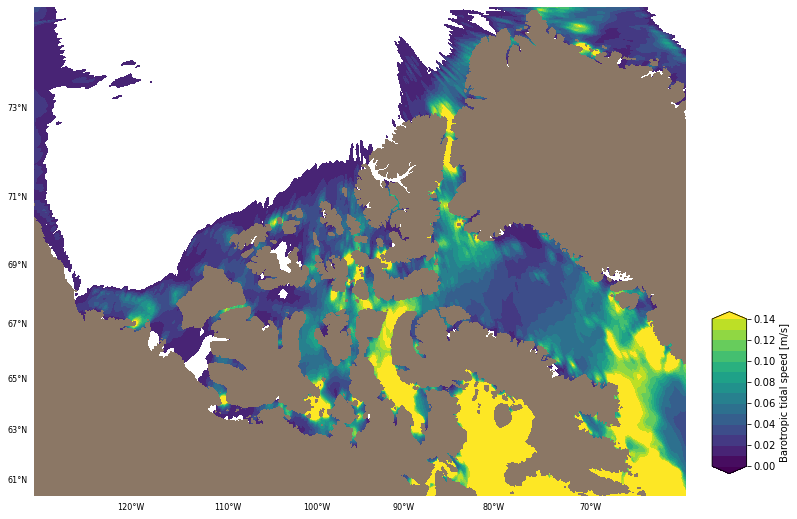

In [12]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
# speed_plot = np.ma.masked_where((tidal_speed_ANHA12 > 0.15), tidal_speed_ANHA12)
speed_plot = np.ma.masked_where((tidal_speed_ANHA12 < 0.01), tidal_speed_ANHA12)
CB = proj1.contourf(x_sub, y_sub, speed_plot, levels=np.arange(0,0.15,0.01), vmin=0, vmax=0.15, extend='both')
                    #[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5], vmin=0, vmax=0.5, extend='both')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, label='Barotropic tidal speed [m/s]')

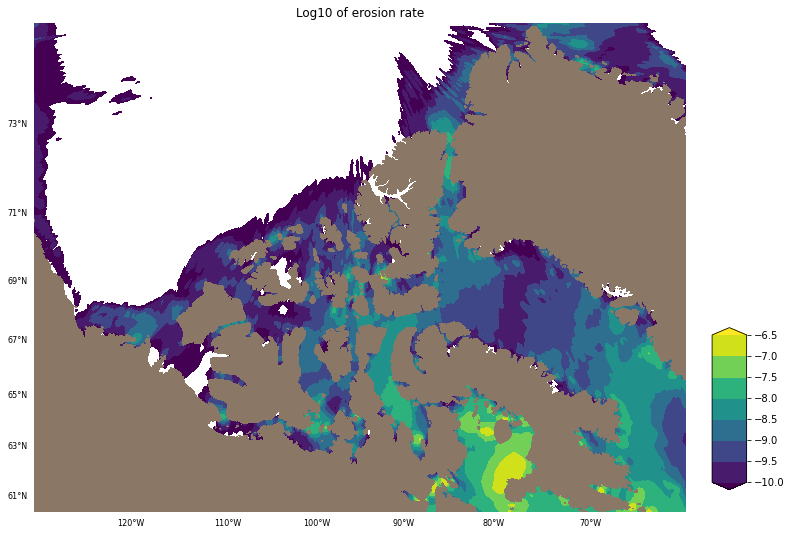

In [12]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
CB = proj1.contourf(x_sub, y_sub, log_erosion_rate, vmin=-10, vmax=-6.5, \
                    levels=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5], extend='both')

ax1.set_title('Log10 of erosion rate')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, ticks=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5])
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---erosion-rate.png', bbox_inches='tight')

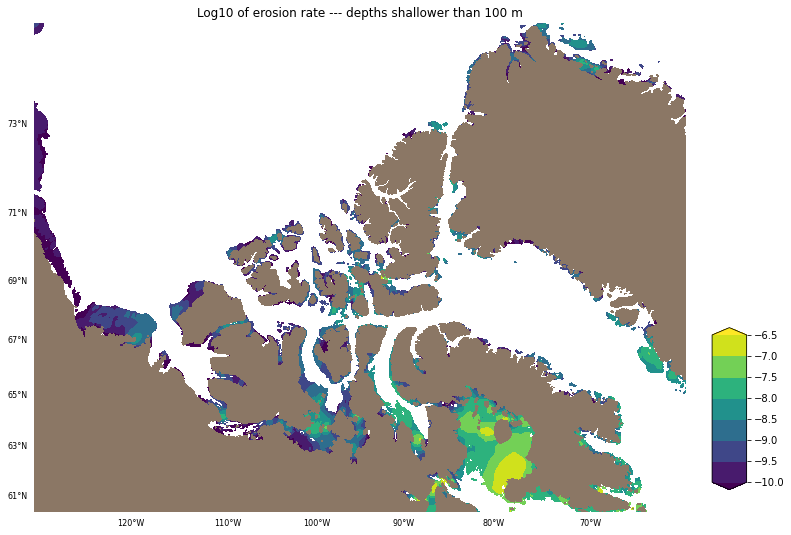

In [26]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
plt_erosion_rate = np.ma.masked_where((mesh_bathy < 0.1), log_erosion_rate)
plt_erosion_rate = np.ma.masked_where((mesh_bathy > 100), plt_erosion_rate)
CB = proj1.contourf(x_sub, y_sub, plt_erosion_rate, vmin=-10, vmax=-6.5, \
                    levels=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5], extend='both')

ax1.set_title('Log10 of erosion rate --- depths shallower than 100 m')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, ticks=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5])
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---erosion-rate.png', bbox_inches='tight')

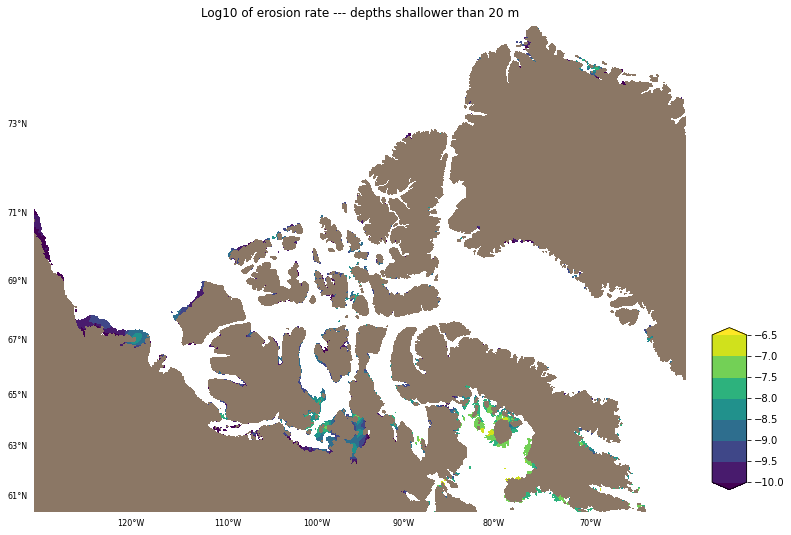

In [27]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
plt_erosion_rate = np.ma.masked_where((mesh_bathy < 0.1), log_erosion_rate)
plt_erosion_rate = np.ma.masked_where((mesh_bathy > 20), plt_erosion_rate)
CB = proj1.contourf(x_sub, y_sub, plt_erosion_rate, vmin=-10, vmax=-6.5, \
                    levels=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5], extend='both')

ax1.set_title('Log10 of erosion rate --- depths shallower than 20 m')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, ticks=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5])
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---erosion-rate.png', bbox_inches='tight')

In [13]:
print('Units [g/m2/yr]')
print('Average erosion rate in domain: ', np.average(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600*9)
print('Maximum erosion rate in domain: ', np.amax(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600*9)
print('Minimum erosion rate in domain: ', np.amin(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600*9)

Units [g/m2/yr]
Average erosion rate in domain:  206.02493586842797
Maximum erosion rate in domain:  40594.35945546213
Minimum erosion rate in domain:  0.0


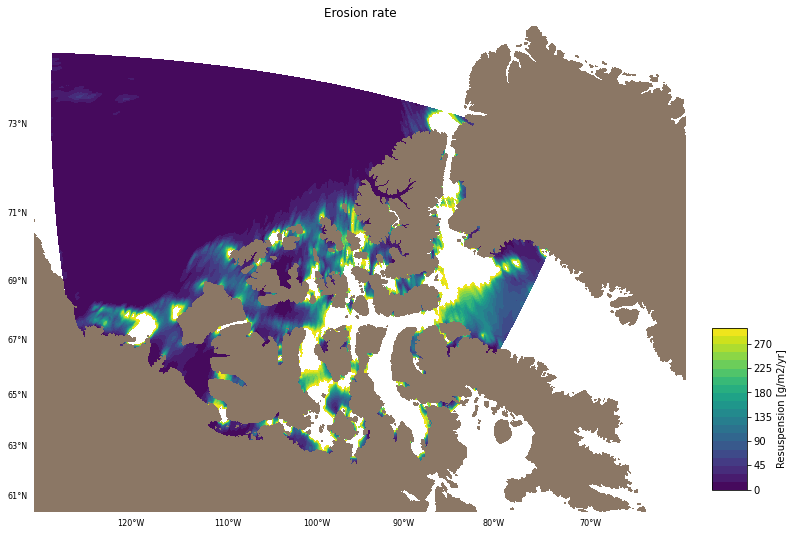

In [51]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
er = erosion_rate[imin:imax, jmin:jmax]*1e3*365*24*3600*9
plt_erosion_rate = np.ma.masked_where((er > 300), er)
# plt_erosion_rate = np.ma.masked_where((mesh_bathy > 20), plt_erosion_rate)
CB = proj1.contourf(x_sub[imin:imax, jmin:jmax], y_sub[imin:imax, jmin:jmax], \
                    plt_erosion_rate, levels=20, vmin=0, vmax=300)

ax1.set_title('Erosion rate')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, label='Resuspension [g/m2/yr]')#, ticks=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5])
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---erosion-rate.png', bbox_inches='tight')

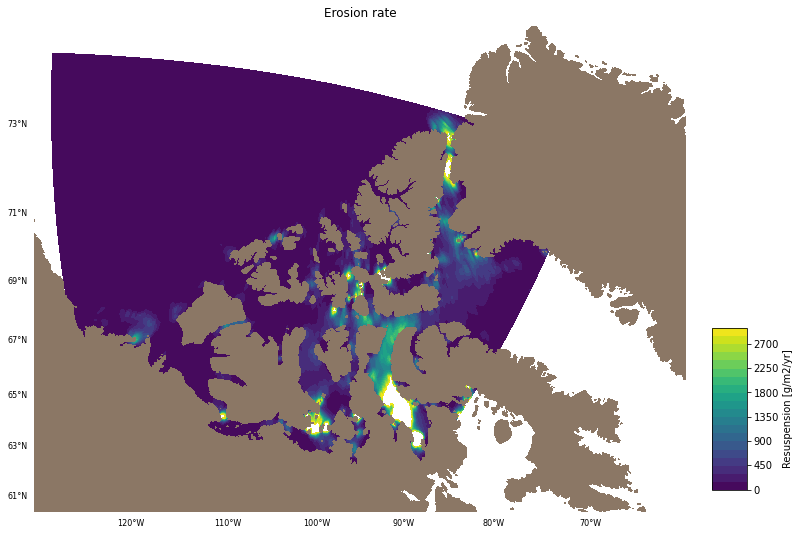

In [14]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
er = erosion_rate[imin:imax, jmin:jmax]*1e3*365*24*3600*9
plt_erosion_rate = np.ma.masked_where((er > 3000), er)
# plt_erosion_rate = np.ma.masked_where((mesh_bathy > 20), plt_erosion_rate)
CB = proj1.contourf(x_sub[imin:imax, jmin:jmax], y_sub[imin:imax, jmin:jmax], \
                    plt_erosion_rate, levels=20, vmin=0, vmax=3000)

ax1.set_title('Erosion rate')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, label='Resuspension [g/m2/yr]')#, ticks=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5])
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---erosion-rate.png', bbox_inches='tight')